In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-22 23:56:28.397242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 23:56:28.411761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 23:56:28.416122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    #'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : [  'uphp_rotated',
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    'use_coeff_channels': False,
                    'single_layer_mask': True,

                    'all_time_range': slice(3600-256, 3600),
                    #'train_time_range': slice(0, 2048),
                    #'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    #'num_train_batches': 128, 
                    #'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],

                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/main_models/window_all/shape_48_48_2/'
                    
            }

In [5]:
experiment_configs = {'1point':{'window_size':1, 'num_inputs':6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'1point'},
                      '3point':{'window_size':3, 'num_inputs':3*3*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'3point'},
                      '5point':{'window_size':5, 'num_inputs':5*5*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'5point'}    
                        }

In [10]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
for key in experiment_configs.keys():

    print('Starting to load in DT for: ' + key)
    
    experiment_configs[key]['DT'] = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                         filter_scales=common_config['filter_scales'], 
                         window_size = experiment_configs[key]['window_size'], 
                         time_sel = common_config['all_time_range'],
                         single_layer_mask_flag=common_config['single_layer_mask']
                         )

    print('Opening up eval sys: ' + key)
    experiment_configs[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=experiment_configs[key]['DT'],
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs=experiment_configs[key]['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=experiment_configs[key]['exp_ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

    print('Reading model and predicting: ' + key)
    
    experiment_configs[key]['eval_sys'].read_ann_regression_model()
    experiment_configs[key]['eval_sys'].read_eval_data()
    experiment_configs[key]['eval_sys'].predict()
    experiment_configs[key]['eval_sys'].dimensionalize()

Starting to load in DT for: 1point
Opening up eval sys: 1point
Reading model and predicting: 1point
Starting to load in DT for: 3point
Opening up eval sys: 3point
Reading model and predicting: 3point
Starting to load in DT for: 5point
Opening up eval sys: 5point
Reading model and predicting: 5point


In [37]:
# Make predictions using GM and VGM models 

for key in experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].add_gradient_model_variables()
    experiment_configs[key]['eval_sys'].add_gent_mcwilliams_variables()

array(0.07677722)

In [50]:
for key in experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='time', dims=['Time'])
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='time', dims=['Time'])

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

In [52]:
for key in experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

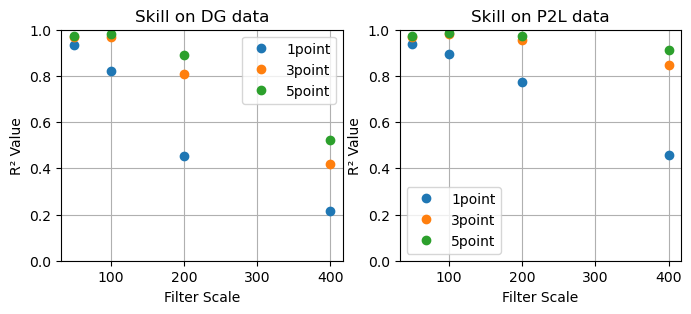

In [33]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_configs.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 3))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in experiment_configs.keys():
        flag = 0
        exp_name = data_key
        
        for scale in common_config['filter_scales']:
            R2_value = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_all.values +
                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R²")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Skill on " + data_key + " data" )

plt.tight_layout()
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

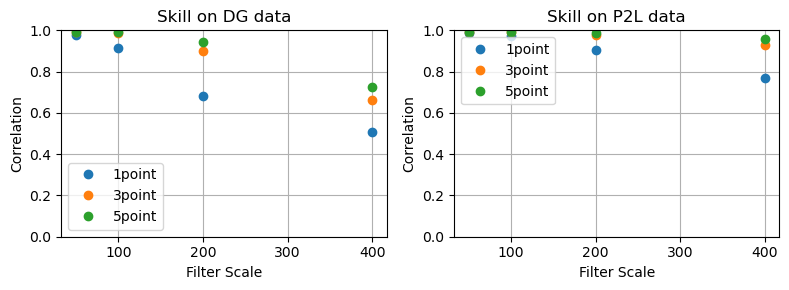

In [34]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_configs.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 3))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in experiment_configs.keys():
        flag = 0
        exp_name = data_key
        
        for scale in common_config['filter_scales']:
            R2_value = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_corr_all.values +
                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_corr_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("Correlation")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Skill on " + data_key + " data" )

plt.tight_layout()
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_configs.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 3))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in experiment_configs.keys():
        flag = 0
        exp_name = data_key
        
        for scale in common_config['filter_scales']:
            R2_value = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_grad_model_all.values +
                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_grad_model_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R²")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Skill on " + data_key + " data with grad model" )

plt.tight_layout()
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_configs.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 3))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in experiment_configs.keys():
        flag = 0
        exp_name = data_key
        
        for scale in common_config['filter_scales']:
            R2_value = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_gent_mcwilliams_all.values +
                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_gent_mcwilliams_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R²")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Skill on " + data_key + " data with grad model" )

plt.tight_layout()
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

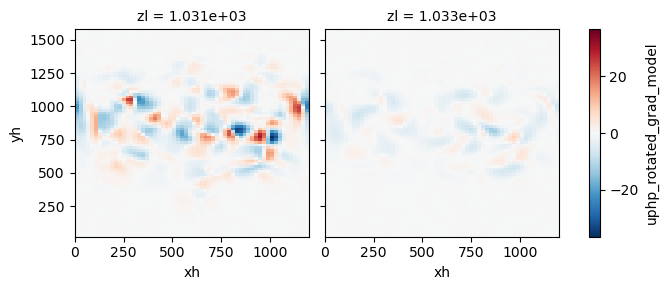

In [48]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_grad_model.isel(Time=0).plot(col='zl')

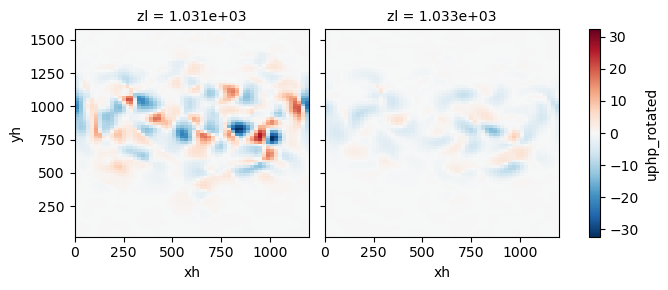

In [49]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_gent_mcwilliams.isel(Time=0).plot(col='zl')

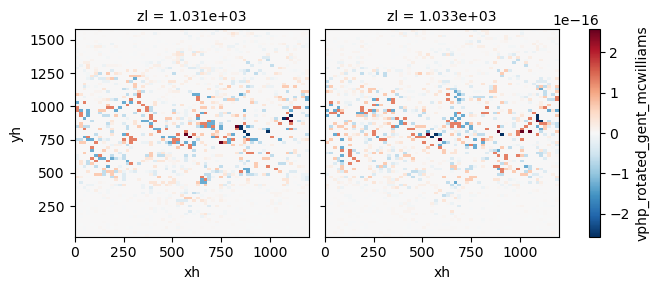

In [54]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].vphp_rotated_gent_mcwilliams.isel(Time=0).plot(col='zl')

CPU times: user 932 ms, sys: 79.4 ms, total: 1.01 s
Wall time: 667 ms


Text(0.5, 1.0, '1point')

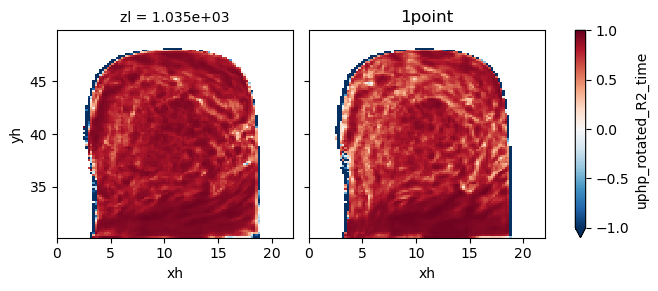

In [24]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('1point')


Text(0.5, 1.0, '1point')

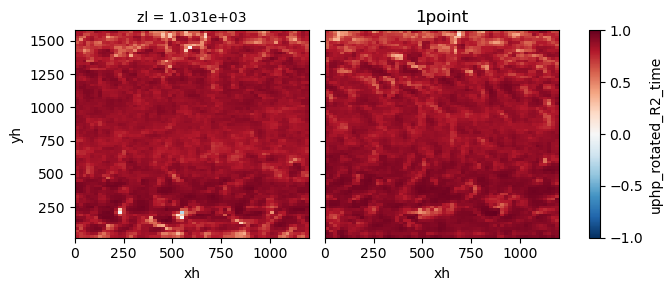

In [19]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('1point')


Text(0.5, 1.0, '3point')

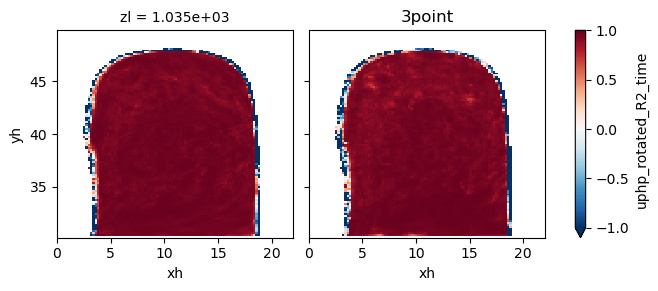

In [16]:
experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('3point')

Text(0.5, 1.0, '3point')

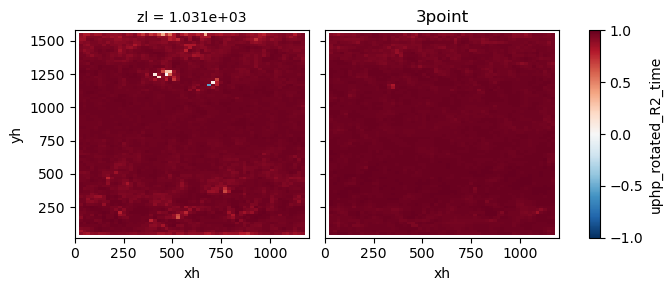

In [22]:
experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('3point')

Text(0.5, 1.0, '5point')

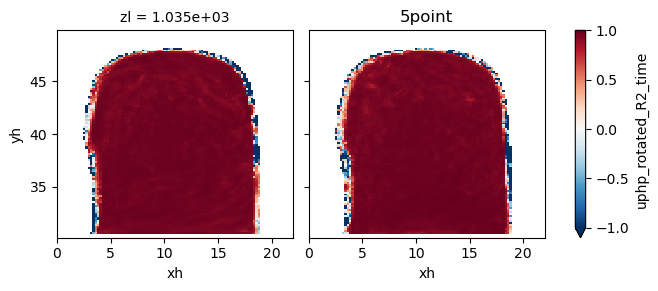

In [17]:
experiment_configs['5point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('5point')

Text(0.5, 1.0, '5point')

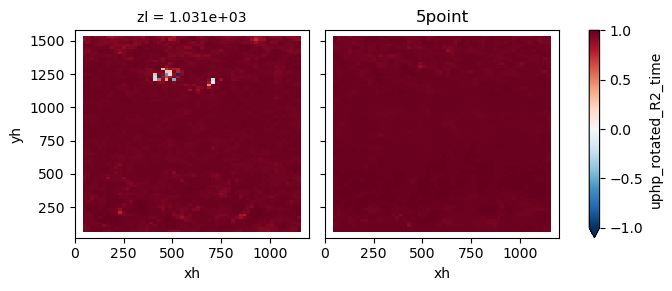

In [23]:
experiment_configs['5point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
plt.title('5point')